Logs 
- [2025/08/09]     
  Apply VQE to solve portfolio optimization problem

In [1]:
import json

import itertools
import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

Objective 
$$
  \argmin_{y_{\ell, i}} \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \gamma_{\ell, i} y_{\ell, i}
  + \frac{1}{2}
    \left(\sum_{\ell\in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell} 
    (\alpha_{\ell,i} y_{\ell,i}) (\alpha_{\ell, j} y_{\ell,j}) \right)
  + C
$$

$$
  = \argmin_{y_{\ell, i}}
    \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \gamma_{\ell, i} y_{\ell, i}
  + 
  \frac{1}{2} \left(\sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} 
    \alpha_{\ell,i}^2 y_{\ell, i}^2
  + \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell \setminus \{i\}}
    2 \alpha_{\ell, i} \alpha_{\ell, j} y_{\ell, i} y_{\ell, j} \right)
  + C
$$

Constraints

`trade_num_upper.limit`
$$
  \left(\sum_{\ell \in L}  \sum_{i \in \mathbb{K}_\ell} y_{\ell, i} \right) \leq M
$$

`limit_sodraw.filterLevel1_sodraw.filterLevel3_#_fund_enriched.pmv`

$$
  K_{\ell}^\text{min} \leq 
    \sum_{i \in \mathbb{K}_{\ell}} \beta_{\ell, i} y_{\ell, i}
    \leq K_{\ell}^\text{max}, \qquad \forall \ell \in L
$$

`limt_sodrtaw.filterLevel1_sodraw.filterLevel3_#_fund_enriched.dxsCtr`

$$
  O_{\ell}^\text{min} \leq 
    \sum_{i \in \mathbb{K}_{\ell}} \varepsilon_{\ell, i} y_{\ell, i}
    \leq O_{\ell}^\text{max}, \qquad \forall \ell \in L
$$

`low_cnstr_cash`

$$
  P^\text{min} \leq \sum_{\ell \in L}  \sum_{i \in \mathbb{K}_\ell}
    \beta_{\ell, i} y_{\ell, i} \leq P^\text{max}
$$

$y_{\ell, i}$ are binary variables

$$
\begin{align*}
  L &= \{1, 2, 3\}  \\
    &= \{\text{Capital Goods}, \text{Insurance}, \text{Transporation}\}
\end{align*}
$$

$$
  \mathbb{K}_{\ell}
  = \begin{cases}
      \begin{aligned}
      \mathbb{K}_1 &= \{1, 2, 3, \ldots, 12\} 
        = \left\{
        \begin{array}{l}
        \texttt{020002BJ9}, \texttt{026874DS3}, \texttt{15135BAW1}, 
        \texttt{21871XAS8}, \texttt{444859BR2}, \\ \texttt{444859BV3}, 
        \texttt{444859BY7}, \texttt{444859CA8}, \texttt{540424AT5}, 
        \texttt{56501RAN6}, \\ \texttt{759351AP4}, \texttt{91324PEJ7} 
        \end{array}
        \right\},
      \end{aligned} \\[16pt]
      \mathbb{K}_2 = \{1, 2, 3, \ldots, 13\}
        = \left\{
        \begin{array}{l}
          \texttt{081437AT2}, \texttt{097023CJ2}, \texttt{14448CBC7}, 
          \texttt{24422EWZ8}, \texttt{24422EXP9}, \\ \texttt{36166NAK9}, 
          \texttt{438516CM6}, \texttt{443201AC2}, \texttt{45687VAB2}, 
          \texttt{539830CD9}, \\ \texttt{75513EAD3}, \texttt{760759BA7}, 
          \texttt{760759BC3}
        \end{array}
        \right\}, \\[16pt]
      \mathbb{K}_3 = \{1, 2, 3, \ldots, 6\}
        = \left\{
        \begin{array}{l}
          \texttt{13645RAD6}, \texttt{13645RBF0}, \texttt{314353AA1}, 
          \texttt{655844CR7}, \texttt{655844CT3}, \\ \texttt{907818FX1}
        \end{array}
        \right\}
    \end{cases}
$$

$$
  M = \texttt{trade\_num\_upper\_limit} = 500
$$

Transform the above constrained problem into unconstrained problem with
Lagrange multipliers

$$
\begin{align*}
&\argmin_{y_{\ell, i}}
    \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \gamma_{\ell, i} y_{\ell, i}
  + 
  \frac{1}{2} \left(\sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \alpha_i^2 y_i^2
  + \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell \setminus \{i\}}
    2 \alpha_i \alpha_j y_i y_j \right) \\
  &\qquad+
    \lambda_1\left(\sum_{\ell \in L}\sum_{i \in \mathbb{K}_\ell}
      y_{\ell, i} - M + s_1^2 
    \right) \\
  &\qquad+ \lambda_2\left( \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - K_1^\text{min} + s_2^2
    \right)
    + \lambda_3\left( \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - K_2^\text{min} + s_3^2
    \right)
    + \lambda_4\left( \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - K_3^\text{min} + s_4^2
    \right) \\
  &\qquad+ \lambda_5\left( \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - K_1^\text{max} + s_5^2
    \right)
    + \lambda_6\left( \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - K_2^\text{max} + s_6^2
    \right)
    + \lambda_7\left( \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - K_3^\text{max} + s_7^2
    \right) \\
  &\qquad+ \lambda_8\left( \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - O_1^\text{min} + s_8^2
    \right)
    + \lambda_9\left( \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - O_2^\text{min} + s_9^2
    \right)
    + \lambda_{10}\left( \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - O_3^\text{min} + s_{10}^2
    \right) \\
  &\qquad+ \lambda_{11}\left( \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - O_1^\text{max} + s_{11}^2
    \right)
    + \lambda_{12}\left( \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - O_2^\text{max} + s_{12}^2
    \right)
    + \lambda_{13}\left( \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - O_3^\text{max} + s_{13}^2
    \right)  \\
  &\qquad+ \lambda_{14}\left(
      \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - P^\text{min} + s_{14}^2
    \right)
    + \lambda_{15}\left( 
      \sum_{\ell \in  L} \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - P^\text{min} + s_{15}^2
    \right)
    + \lambda_{16}\left( 
        \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - P^\text{min} + s_{16}^2
    \right) \\
  &\qquad+ \lambda_{17}\left(
      \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}\beta_{1, i} y_{1, i}
      - P^\text{max} + s_{17}^2
    \right)
    + \lambda_{18}\left( 
      \sum_{\ell \in  L} \sum_{i \in \mathbb{K}_\ell}\beta_{2, i} y_{2, i}
      - P^\text{max} + s_{18}^2
    \right)
    + \lambda_{19}\left( 
        \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}\beta_{3, i} y_{3, i}
      - P^\text{max} + s_{19}^2
    \right) 
  + C
\end{align*}
$$

### Solve with one constraint `trade_num_upper.limit`

$$
\begin{align*}
\operatorname*{arg min}_{y_{\ell, i}} \,
  \frac{1}{2} \left(
  \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell}
     y_{\ell, i} \alpha_{\ell, i} \alpha_{\ell, j}  y_{\ell, j} \right) 
  - \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}
        (-\gamma_{\ell, i} - \lambda_1) y_{\ell, i}
    + \lambda_1\left( - M + s_1^2 \right)
\end{align*}
$$

use the transformation $y_{\ell, i} = \dfrac{1 - z_{\ell, i}}{2}$

$$
\begin{align*}
&= \operatorname*{arg min}_{z_{\ell, i} \in \{-1, 1\}} \,
  \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell \setminus \{i\}}
     \frac{\alpha_{\ell, i} \alpha_{\ell, j} }{4}z_{\ell, i}  z_{\ell, j} 
  - \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}
      \left(
        -\frac{1}{4}\sum_{j \in \mathbb{K}_{\ell}}
        \alpha_{\ell, i} \alpha_{\ell, j}
        + \frac{(-\gamma_{\ell, i} - \lambda_1)}{2}
      \right)z_{\ell, i} \\
  &\qquad + \frac{1}{8} \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} \sum_{j \in \mathbb{K}_\ell} 
     \alpha_{\ell, i} \alpha_{\ell, j}
    + \frac{1}{8} \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell}  \alpha_{\ell, i}^2
    + \frac{1}{2} \sum_{\ell \in L} \sum_{i \in \mathbb{K}_\ell} (-\gamma_{\ell, i} - \lambda_1)
     + \lambda_1\left( - M + s_1^2 \right)
\end{align*}
$$

Load the data

In [3]:
with open("./data/1/31bonds/docplex-bin-avgonly-nocplexvars.json", 'r') as fp:
  bonds_data = json.load(fp) 

bonds_data

{'var': ['020002BJ9',
  '026874DS3',
  '081437AT2',
  '097023CJ2',
  '13645RAD6',
  '13645RBF0',
  '14448CBC7',
  '15135BAW1',
  '21871XAS8',
  '24422EWZ8',
  '24422EXP9',
  '314353AA1',
  '36166NAK9',
  '438516CM6',
  '443201AC2',
  '444859BR2',
  '444859BV3',
  '444859BY7',
  '444859CA8',
  '45687VAB2',
  '539830CD9',
  '540424AT5',
  '56501RAN6',
  '655844CR7',
  '655844CT3',
  '75513EAD3',
  '759351AP4',
  '760759BA7',
  '760759BC3',
  '907818FX1',
  '91324PEJ7'],
 'gamma': [-171.843480141259,
  -209.916098093165,
  -208.476006609091,
  -102.658455587925,
  -108.872687135303,
  -59.317668233044,
  -248.173707501463,
  -181.705222582624,
  -217.516328228335,
  -150.364227654476,
  -238.537754989087,
  -64.315591692518,
  -232.71668457355,
  -231.561240438637,
  -133.172276708478,
  -111.860973316693,
  -215.624770871618,
  -216.444892837478,
  -210.050748767208,
  -98.56277968679,
  -234.562738134276,
  -195.144598835887,
  -194.556369478498,
  -190.182474291791,
  -26.345955030805,

In [4]:
bonds_data["M"]

500.0

In [5]:
# Define parameters for the Hamiltonian
n = 10    # number of bonds
M = bonds_data["M"]
alpha_arr = bonds_data["alpha"]
gamma_arr = bonds_data["gamma"]
_lambda_arr = [1.]    # langrange multiplier
_slack_arr = [5.]      # slack variable

In [6]:
# Design the ansatz

def strongly_entangling_ansatz(params, num_of_qubits):
  """
  From PennyLane Codercise V.2.1 - Introduction to VQE
  """
  qml.StronglyEntanglingLayers(weights=params, wires=range(num_of_qubits))

In [7]:
# Define Hamiltonian
ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(n) for j in range(i+1, n)]
ZZ_coeff = [0.25*alpha_arr[i]*alpha_arr[j] for i in range(n) for j in range(i+1, n)]

Z = [qml.PauliZ(i) for i in range(n)]
Z_coeff = [-0.25*sum(alpha_arr[i]*alpha_arr[j] for j in range(n)) 
  + 0.5*(-gamma_arr[i] - _lambda_arr[0]) for i in range(n)]

observables = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, observables, grouping_type="qwc")

In [18]:
# dev = qml.device("lightning.gpu", wires=n, batch_obs=True)   # need high memory GPU (> 20 qubits)
dev = qml.device("lightning.qubit", wires=n)    # use this
# dev = qml.device("default.qubit", wires=n)   # freezing

# -- using matrix product states (need quimb module)
# dev = qml.device("defaut.tensor", method="mps", max_bond_dim=50,
#                   cutoff=np.finfo(np.complex128).eps, contrat="auto_mps")


# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x, n, H):
  strongly_entangling_ansatz(x, n)

  return qml.expval(H)

@qml.qnode(dev)
def probability_circuit(params, n):
  strongly_entangling_ansatz(params, n)

  return qml.probs(wires=range(n))

In [19]:
p = 2   # circuit repetition

seed = None
rng = np.random.default_rng(seed)
init_params = rng.random(size=(p, n, 3))

print(qml.draw(cost)(init_params, n, H))

0: ──Rot(0.74,0.25,0.93)─╭●─────────────────────────╭X──Rot(0.61,0.98,0.46)─╭●────────────────── ···
1: ──Rot(0.93,0.58,0.76)─╰X─╭●──────────────────────│───Rot(0.74,0.39,0.13)─│──╭●─────────────── ···
2: ──Rot(0.37,0.26,0.91)────╰X─╭●───────────────────│───Rot(0.22,0.78,0.52)─╰X─│──╭●──────────── ···
3: ──Rot(0.20,0.03,0.56)───────╰X─╭●────────────────│───Rot(0.83,0.15,0.00)────╰X─│──╭●───────── ···
4: ──Rot(0.49,0.18,0.36)──────────╰X─╭●─────────────│───Rot(0.38,0.95,0.77)───────╰X─│──╭●────── ···
5: ──Rot(0.60,0.51,0.00)─────────────╰X─╭●──────────│───Rot(0.03,0.94,0.74)──────────╰X─│──╭●─── ···
6: ──Rot(0.15,0.61,0.07)────────────────╰X─╭●───────│───Rot(0.39,0.29,0.21)─────────────╰X─│──╭● ···
7: ──Rot(0.22,0.11,0.32)───────────────────╰X─╭●────│───Rot(0.51,0.43,0.76)────────────────╰X─│─ ···
8: ──Rot(0.51,0.37,0.10)──────────────────────╰X─╭●─│───Rot(0.30,0.88,0.07)───────────────────╰X ···
9: ──Rot(0.33,0.56,0.32)─────────────────────────╰X─╰●──Rot(0.11,0.38,0.68)────────────────

In [20]:
p = 2   # circuit repetition

learning_rate = 0.001
opt = qml.QNGOptimizer(stepsize=learning_rate)

max_steps = 1000
print_multiplier = 5

seed = None
rng = np.random.default_rng(seed)
params = rng.random(size=(p, n, 3))

old_cost = 9_999.
cost_func_history = []
for i in range(max_steps):
  params = opt.step(cost, params, n, H)[0]
  obj_value = cost(params, n, H)
  cost_func_history.append(obj_value)

  if (i + 1) % print_multiplier == 0:
    print(f"Cost after step {i+1:5d}: {obj_value: .7f}")

    if np.round(old_cost, 7) == np.round(obj_value, 7):
      break
    else:
      old_cost = obj_value

print(f"Optimized parameters: {params}")
print(f"Optimized objective function value: {obj_value}")

Cost after step     5: -63.2315112
Cost after step    10: -109.7391657
Cost after step    15: -167.9003474
Cost after step    20: -384.0684499
Cost after step    25: -403.2357127
Cost after step    30: -403.6356317
Cost after step    35: -403.8373565
Cost after step    40: -403.9820331
Cost after step    45: -404.0863497
Cost after step    50: -404.1612579
Cost after step    55: -404.2148769
Cost after step    60: -404.2531691
Cost after step    65: -404.2804708
Cost after step    70: -404.2999136
Cost after step    75: -404.3137483
Cost after step    80: -404.3235865
Cost after step    85: -404.3305799
Cost after step    90: -404.3355495
Cost after step    95: -404.3390802
Cost after step   100: -404.3415883
Cost after step   105: -404.3433697
Cost after step   110: -404.3446350
Cost after step   115: -404.3455335
Cost after step   120: -404.3461716
Cost after step   125: -404.3466248
Cost after step   130: -404.3469466
Cost after step   135: -404.3471751
Cost after step   140: -404.3

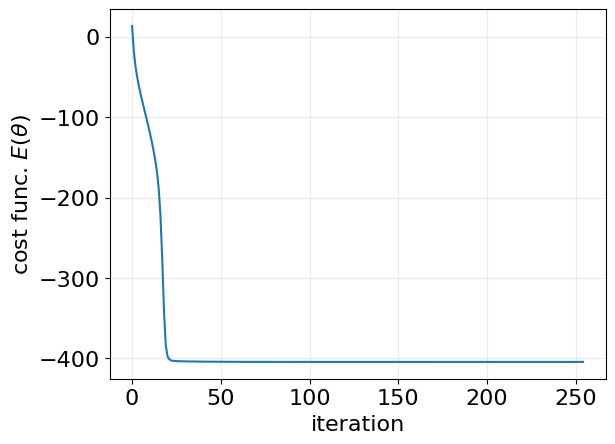

In [21]:
fig, ax = plt.subplots()

ax.plot(cost_func_history)
ax.grid("on")

ax.set_ylabel(r"cost func. $E(\theta)$")
ax.set_xlabel("iteration")
plt.show(fig)

Check the exact ground state solution

In [22]:
all_combinations = itertools.product([0, 1], repeat=n)

exact_E_g = 9_999.
for exact_x in all_combinations:
  exact_E = sum(gamma_arr[i]*exact_x[i] for i in range(n)) \
    + 0.5*(sum((alpha_arr[i]*exact_x[i])**2 for i in range(n))
           + 2.*sum(alpha_arr[i]*exact_x[i]*alpha_arr[j]*exact_x[j]
                    for i in range(n) for j in range(i+1, n))) 
  if exact_E < exact_E_g:
    exact_E_g = exact_E
    exact_sol = exact_x

print(f"Exact solution: {exact_sol}")

Exact solution: (1, 1, 1, 1, 0, 0, 1, 1, 1, 1)


Final solution : 111001111, with prob=1.00000


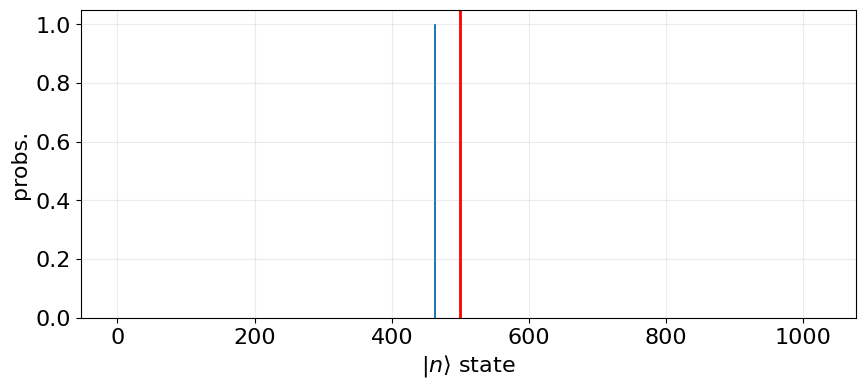

In [23]:
probs = probability_circuit(params, n)
print("Final solution : {:06b}, with prob={:.5f}".format(np.argmax(probs), max(probs)))

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(range(2 ** len(range(n))), probs, width=4)
ax.grid("on")

ax.set_ylabel("probs.")
ax.set_xlabel(r"$|n\rangle$ state")

ax.axvline(500, c="r", linewidth=2)

plt.show(fig)

In [14]:
threshold = 0.15
idx_sol = np.argwhere(probs > threshold)
print(idx_sol)

for sol in idx_sol:
  print(f"{sol[0]:010b}")

[]
